# Анализ дорожно-транспортных происшествий (ДТП) в России

## Описание проекта
Данный проект представляет собой разведочный анализ данных о ДТП в России. Целью является выявление ключевых тенденций, распределения аварий по регионам, времени и условиям, а также оценка тяжести происшествий. Анализ основан на выборочных очищенных данных, предоставленных для воспроизводимости без использования облачных источников.

## Цели анализа
- Изучить динамику числа ДТП и погибших за несколько лет.
- Проанализировать распределение аварий по регионам, времени суток, погодным условиям, участникам и пр.
- Оценить связь факторов (тип ДТП, возраст транспорта, нарушения) и тяжесть происшествий.

## Структура данных
- `accidents`: Основной набор данных о ДТП (около 1000 записей), включая дату, регион, тип и тяжесть.
- `participants`: Данные об участниках происшествий (более 2500 записей), включая роль и нарушения.
- `vehicles`: Информация о транспортных средствах (более 1500 записей), включая возраст и категорию.

## О выборочных данных
В данном ноутбуке для быстрой воспроизводимости результатов используются выборочные данные из файла `cleaned_accidents.csv`. Полный анализ с адекватными результатами представлен в отдельном файле с полными данными.

## Источники данных
см. `../README.md`

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Добавляем путь к скриптам
sys.path.append(os.path.abspath("../scripts"))

from utils import load_data

# Загрузка данных
DATA_DIR = "../data"
accidents, participants, vehicles = load_data(DATA_DIR, sample=True)

# Динамика числа ДТП по годам и месяцам

## Описание задачи

Следующая ячейка анализирует многолетнюю динамику числа дорожно-транспортных происшествий (ДТП) в России на основе выборочных данных. Цель — выявить тенденции изменения количества аварий и погибших по месяцам и годам.

## Данные

Используются данные из таблицы `accidents`, агрегированные по годам и месяцам с расчётом общего числа ДТП и погибших.

In [4]:
# Импорт библиотек
import sys
import pandas as pd
import plotly.graph_objects as go

# Импорт функций из модуля utils
sys.path.append("C:/Users/Admin/Road-Crash-Analysis/scripts")
from utils import aggregate_accidents

# Константы для стилей
FIGURE_WIDTH = 800
FIGURE_HEIGHT = 400
MARKER_SIZE = 8
GRID_COLOR = "#e0e0e0"

# Агрегация данных по годам и месяцам
monthly_stats = (
    accidents
    .groupby(['year', 'month'])
    .agg(
        accident_count=('dead_count', 'size'),
        dead_count    =('dead_count', 'sum')
    )
    .reset_index()
)

# Подготовка меток для оси X (только первый месяц каждого года)
time_labels = []
tick_positions = []
current_year = None
for i, (year, month) in enumerate(zip(monthly_stats["year"], monthly_stats["month"])):
    if year != current_year:
        time_labels.append(f"{year}-{month:02d}")
        tick_positions.append(i)
        current_year = year

# Построение интерактивного графика
fig = go.Figure()

# Добавление линии для числа ДТП
fig.add_trace(
    go.Scatter(
        x=list(range(len(monthly_stats))),
        y=monthly_stats["accident_count"],
        mode="lines+markers",
        name="ДТП",
        line=dict(color="blue", width=2),
        marker=dict(size=MARKER_SIZE)
    )
)

# Добавление вертикальных линий для разделения годов
for pos in tick_positions[1:]:  # Пропускаем первую метку (2015)
    fig.add_shape(
        type="line",
        x0=pos, y0=0,
        x1=pos, y1=max(monthly_stats["accident_count"]),
        line=dict(color="gray", width=1, dash="dash")
    )

# Настройка макета графика
fig.update_layout(
    title="Динамика числа ДТП по годам и месяцам",
    xaxis_title="Время (год-месяц)",
    yaxis_title="Количество ДТП",
    xaxis=dict(
        tickmode="array",
        tickvals=tick_positions,
        ticktext=time_labels,
        tickangle=0,  # Убрали поворот для читаемости
        tickfont=dict(size=10)
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor=GRID_COLOR,
        gridwidth=1,
        zeroline=False
    ),
    width=FIGURE_WIDTH,
    height=FIGURE_HEIGHT,
    showlegend=True
)

fig.show()

## Выводы

- За рассматриваемый период (2015–2024) наблюдается тенденция к постепенному снижению общего числа ДТП, особенно начиная с 2017 года.
- График демонстрирует заметные колебания внутри года, что связано с небольшой выборкой данных и сезонными факторами.
- Для более точного анализа требуется увеличить объём данных.

# Распределение ДТП по месяцам

## Описание задачи

В следующей ячейке выполняется анализ распределения числа дорожно-транспортных происшествий (ДТП) по месяцам с учётом разной длины месяцев. Цель — выявить сезонные закономерности, рассчитав среднедневное число ДТП для каждого месяца за все годы.

## Данные

Используются агрегированные данные из таблицы `monthly_stats`, содержащей количество ДТП по годам и месяцам.

In [7]:
# Импорт библиотек
import sys
import pandas as pd
import calendar
from utils import aggregate_accidents

# Агрегация данных по годам и месяцам (если ещё не выполнена)
if "accident_count" not in monthly_stats.columns:
    agg_dict = {"dead_count": ["size", "sum"]}
    monthly_stats = aggregate_accidents(accidents, ["year", "month"], agg_dict)

# Вычисление числа дней в каждом месяце (векторизованный подход)
monthly_stats["days_per_month"] = monthly_stats.apply(
    lambda row: calendar.monthrange(row["year"], row["month"])[1], axis=1
)

# Расчёт среднедневного числа ДТП
monthly_stats["accidents_per_day"] = (
    monthly_stats["accident_count"] / monthly_stats["days_per_month"]
).round(3)

# Сортировка данных для удобства
monthly_stats = monthly_stats.sort_values(by=["year", "month"]).reset_index(drop=True)

# Агрегация взвешенных данных по месяцам
weighted_data = (
    monthly_stats.groupby("month", group_keys=False)
    .apply(lambda group: pd.Series({
        "total_accidents": group["accident_count"].sum(),
        "total_days_count": group["days_per_month"].sum()
    }))
    .reset_index()
)

# Расчёт среднего числа ДТП в день
weighted_data["avg_daily_accident"] = (
    weighted_data["total_accidents"] / weighted_data["total_days_count"]
).round(3)

# Проверка результата
display(weighted_data)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14388\949206481.py:28: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



month  total_accidents  total_days_count  avg_daily_accident
0       1               86               310               0.277
1       2               66               283               0.233
2       3               63               310               0.203
3       4               81               300               0.270
4       5               86               310               0.277
5       6               81               270               0.300
6       7               92               279               0.330
7       8               97               279               0.348
8       9               94               270               0.348
9      10               81               279               0.290
10     11               90               270               0.333
11     12               83               279               0.297

# Построение графика для распределения ДТП по месяцам

## Описание задачи

В следующей ячейке строится полярная диаграмма, отображающая среднее число ДТП в день для каждого месяца за все годы. Данные учитывают разную длину месяцев для корректного сравнения.

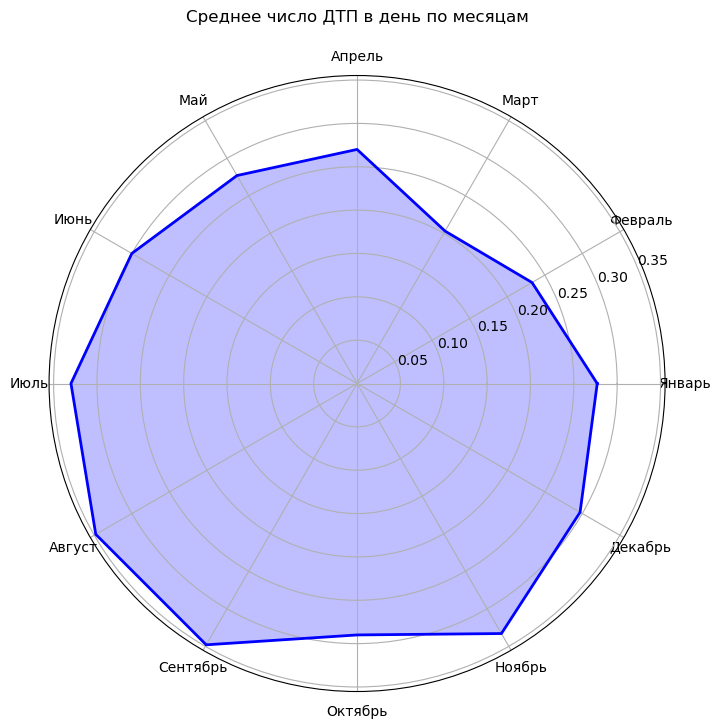

In [9]:
# Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt

# Константы для стилей
FIGURE_SIZE = (8, 8)
LINE_COLOR = "blue"
LINE_WIDTH = 2
FILL_ALPHA = 0.25
FONT_SIZE = 10

# Словарь с русскими названиями месяцев
month_names_ru = {
    1: "Январь", 2: "Февраль", 3: "Март", 4: "Апрель",
    5: "Май", 6: "Июнь", 7: "Июль", 8: "Август",
    9: "Сентябрь", 10: "Октябрь", 11: "Ноябрь", 12: "Декабрь"
}

# Подготовка данных
month_labels = weighted_data["month"].map(month_names_ru).tolist()
daily_accidents = weighted_data["avg_daily_accident"].tolist()

# Закрытие круга для полярной диаграммы
angles = np.linspace(0, 2 * np.pi, len(month_labels), endpoint=False).tolist()
daily_accidents.append(daily_accidents[0])
angles.append(angles[0])

# Построение полярной диаграммы
fig, ax = plt.subplots(figsize=FIGURE_SIZE, subplot_kw={"projection": "polar"})
ax.plot(angles, daily_accidents, linewidth=LINE_WIDTH, linestyle="solid", color=LINE_COLOR)
ax.fill(angles, daily_accidents, color=LINE_COLOR, alpha=FILL_ALPHA)

# Настройка меток и заголовка
ax.set_xticks(angles[:-1])
ax.set_xticklabels(month_labels, fontsize=FONT_SIZE)
ax.set_title("Среднее число ДТП в день по месяцам", fontsize=12, pad=20)

# Отображение графика
plt.show()

## Выводы

- Летние месяцы (июнь–август) и сентябрь демонстрируют более высокие значения среднедневного числа ДТП, что может быть связано с увеличением числа поездок в отпускной сезон и ростом интенсивности движения.
- Весенние месяцы (февраль–март) характеризуются более низкими значениями, что может быть обусловлено улучшением дорожных условий после зимы и меньшей интенсивностью движения.

## Распределение ДТП по часам суток

В этом разделе мы анализируем, как меняется число аварий в зависимости от часа суток. Сначала приведём даты в формат `datetime`, выделим час, затем подсчитаем количество ДТП по каждому часу и построим интерактивный график.

In [12]:
# Импортируем утилиты
from utils import plotly_line_chart
import pandas as pd

# Конвертация столбца в datetime и выделение часа
accidents['datetime'] = pd.to_datetime(accidents['datetime'])
accidents['hour']     = accidents['datetime'].dt.hour

# Группировка: подсчитываем число ДТП по часам и сортируем по возрастанию часа
accidents_by_hour = (
    accidents
    .groupby('hour')
    .size()
    .reset_index(name='accident_count')
    .sort_values('hour')
)

# Визуализация
plotly_line_chart(
    x        = accidents_by_hour['hour'],
    y        = accidents_by_hour['accident_count'],
    x_labels = accidents_by_hour['hour'].astype(str).tolist(),
    title    = 'Распределение ДТП по часам суток',
    xlabel   = 'Час суток',
    ylabel   = 'Количество ДТП'
)

## Выводы

- **Минимум аварий** приходится на ночные часы (0–4), когда интенсивность движения минимальная.  
- **Рост числа ДТП** начинается с 5–6 ч утра и достигает локального пика в 8 ч (утренний час пик).  
- После небольшого спада в 9 ч аварии постепенно нарастают и **максимум** фиксируется в 17–19 ч (вечерний час пик).  
- Далее к ночи число аварий стремительно снижается.

## Динамика числа погибших на одно ДТП по годам

В этом разделе рассчитываем показатель “погибших на одно ДТП” в разрезе годов и строим интерактивный график для выявления трендов: рост/снижение тяжести ДТП на дорогах.

In [15]:
from utils import compute_death_rate
import plotly.express as px
import pandas as pd

# Рассчитываем число ДТП, число погибших и их отношение по годам
severity_by_year = compute_death_rate (accidents, group_col='year', value_col='dead_count')

# Строим базовый график
idx = list(range(len(severity_by_year)))
fig = px.line(
    x = idx,
    y = severity_by_year['deaths_per_accident'],
    markers=True,
    title='Погибшие на одно ДТП по годам'
)

# Подписи оси X — годы
fig.update_layout(
    xaxis=dict(
        tickmode='array',
        tickvals=idx,
        ticktext=severity_by_year['year'].astype(str).tolist()
    ),
    xaxis_title='Год',
    yaxis_title='Погибших на одно ДТП',
    template='simple_white'
)

# Находим пик по 2017
peak_row  = severity_by_year[severity_by_year['year'] == 2017].iloc[0]
peak_idx  = severity_by_year.index[severity_by_year['year'] == 2017][0]
peak_value= peak_row['deaths_per_accident']

# Добавляем аннотацию
fig.add_annotation(
    x=peak_idx,
    y=peak_value,
    text=f"Пик в 2017: {peak_value:.2f}",
    showarrow=True,
    arrowhead=2,
    ax=0,        # смещение текста по x
    ay=-40,      # смещение текста по y
    font=dict(size=12)
)
fig.show()

## Выводы

- В 2017 году показатель **`погибших на одно ДТП`** достигает максимума.  
- С 2017 г. наблюдается устойчивое снижение «смертности», к 2024 г. достигается минимум.  
- Общая динамика свидетельствует о повышении безопасности на дорогах за последние годы.

## Тяжесть ДТП по регионам

Здесь рассчитываем смертность на одно ДТП для каждого региона и строим бар-чарт с вертикальными столбцами.

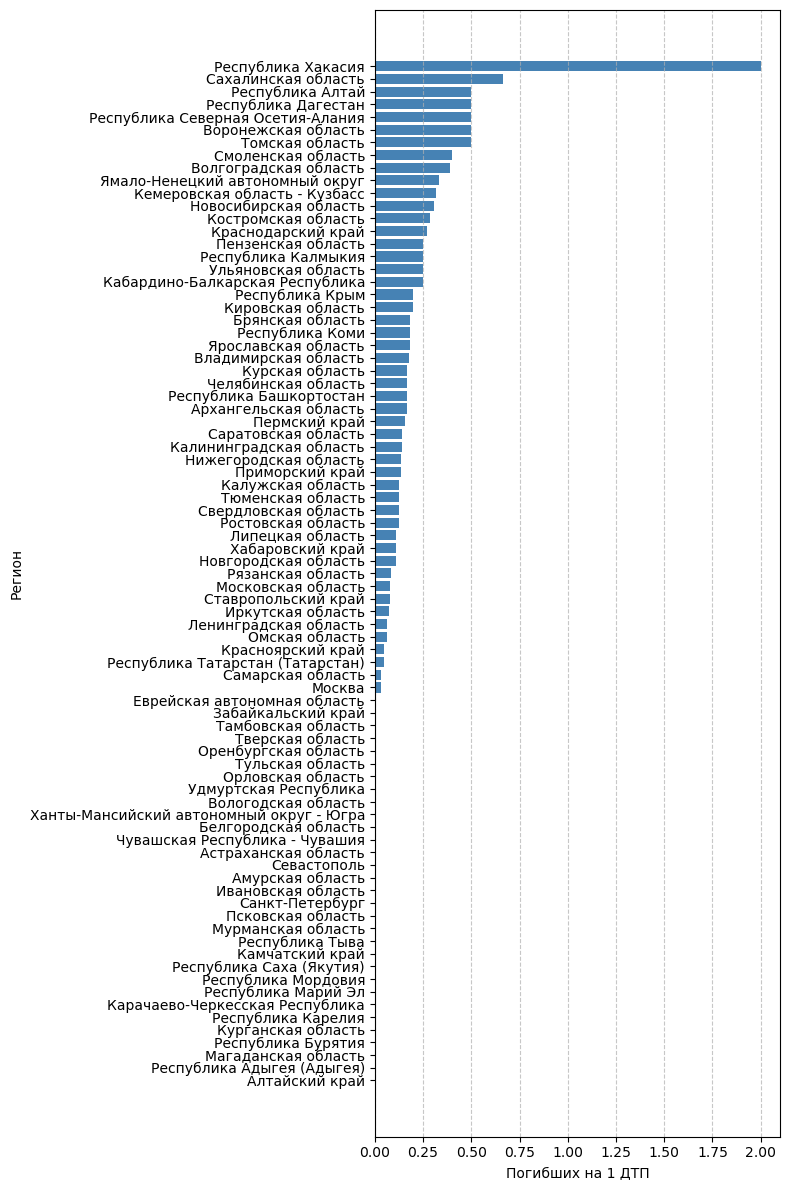

In [18]:
from utils import compute_death_rate, plotly_bar_chart, plot_bar_chart
import pandas as pd

# Считаем число ДТП, число погибших и их отношение по регионам
severity_by_region = compute_death_rate(
    df        = accidents,
    group_col = 'region',
    value_col = 'dead_count'
)

# Сортируем по убыванию смертности на ДТП
severity_by_region = severity_by_region.sort_values(
    by = 'deaths_per_accident',
    ascending = False
).reset_index(drop=True)

# Строим вертикальный бар-чарт
plt.figure(figsize=(8, 12))
plt.barh(
    y=severity_by_region['region'],
    width=severity_by_region['deaths_per_accident'],
    color='steelblue'
)
plt.xlabel('Погибших на 1 ДТП')
plt.ylabel('Регион')
plt.gca().invert_yaxis()  # самые «тяжёлые» регионы сверху
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Выводы

- Наибольшая смертность (большее число погибших на ДТП) наблюдается в отдельной группе регионов (верхние столбцы).  
- Во многих регионах показатель близок к нулю — это следствие малого размера выборки (несколько аварий дают либо 0, либо 2–3 погибших, что искажает среднюю).  

## Карта числа ДТП по регионам

**Источник данных** см. `../README.md`

В этом блоке мы:
1. Загружаем GeoJSON с границами регионов России и нормализуем названия;
2. Считаем число ДТП по каждому региону;
3. Строим статическую карту через GeoPandas/Matplotlib;

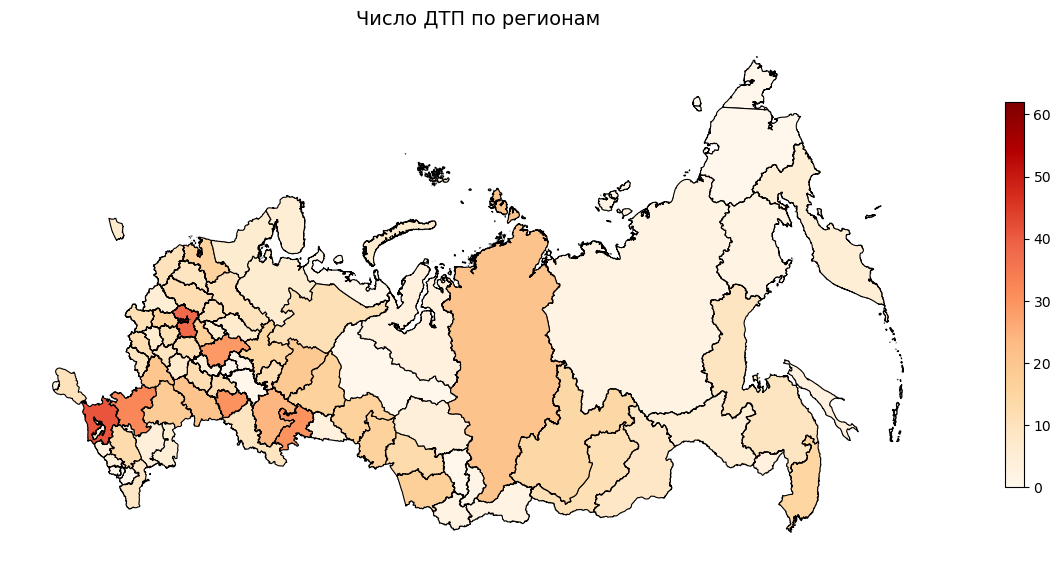

In [21]:
from utils import load_and_merge_geodata
import matplotlib.pyplot as plt

# Подсчёт числа ДТП по регионам
region_accidents = (
    accidents
    .groupby("region")
    .agg(accident_number=("id", "size"))
    .reset_index()
)

# Загрузка и объединение геоданных
regions_gdf = load_and_merge_geodata(
    geofile_path="../data/russia_regions.geojson",
    accidents_data=region_accidents,
    region_col="region"
)

# Статическая карта
fig, ax = plt.subplots(figsize=(12, 8))
regions_gdf.plot(
    column="accident_number",
    cmap="OrRd",
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax,
    legend_kwds={"shrink": 0.5},
    missing_kwds={"color": "lightgrey"}
)
ax.set_title("Число ДТП по регионам", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


## Карта социального риска: ДТП на 100 000 человек

В этом блоке:
1. Оставляем только регионы с ненулевой численностью населения.
2. Считаем число ДТП на 100 000 человек населения.
3. Строим статическую карту в том же стиле, что и карту числа ДТП.

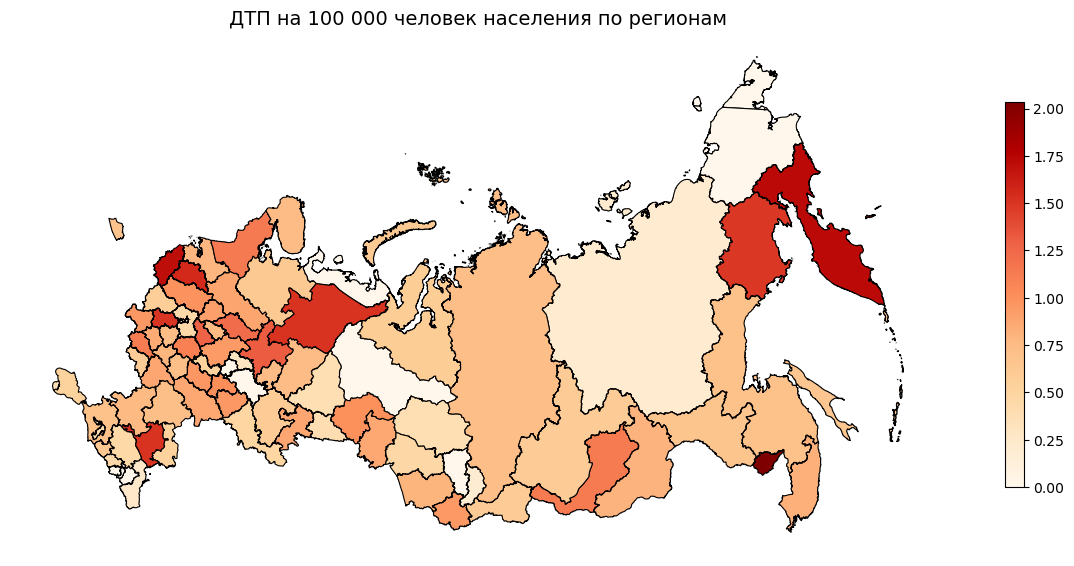

In [23]:
import matplotlib.pyplot as plt

# Фильтрация регионов с ненулевой популяцией
regions_gdf = regions_gdf[regions_gdf['population'] > 0].copy()

# Расчёт ДТП на 100 000 человек
regions_gdf['accidents_per_100k'] = (
    regions_gdf['accident_number'] 
    / regions_gdf['population'] 
    * 100_000
)

# Статическая карта социального риска
fig, ax = plt.subplots(figsize=(12, 8))
regions_gdf.plot(
    column="accidents_per_100k",
    cmap="OrRd",
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax,
    legend_kwds={"shrink": 0.5},
    missing_kwds={"color": "lightgrey"}
)
ax.set_title("ДТП на 100 000 человек населения по регионам", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

## Выводы

- Карта показывает социальный риск ДТП, скорректированный на численность населения.  
- Тёмные регионы имеют более высокий показатель ДТП на 100 000 человек, что позволяет выделить зоны с наибольшим риском.  

## Тяжесть ДТП по типам ДТП

В этом блоке мы:
1. Группируем данные по типу ДТП (`category`) и считаем:
   - `accident_count` – число аварий;
   - `death_count` – число погибших;
   - `participants_count` – общее число участников.
2. Рассчитываем показатель `fatality_rate` = (число погибших / число участников) × 100.
3. Выводим две таблицы:
   - **Топ категорий по числу ДТП**;
   - **Топ категорий по уровню летальности** (fatality_rate).

In [26]:
from utils import aggregate_metrics, compute_rate
from IPython.display import display

# 1) Агрегация метрик по типу ДТП
severity_by_category = aggregate_metrics(
    df        = accidents,
    group_col = 'category',
    metrics   = {
        'accident_count':     ('id',                'size'),
        'death_count':        ('dead_count',        'sum'),
        'participants_count': ('participants_count','sum')
    }
)

# 2) Расчёт fatality_rate = (dead_count / participants_count) * 100
severity_by_category = compute_rate(
    df          = severity_by_category,
    numerator   = 'death_count',
    denominator = 'participants_count',
    new_col     = 'fatality_rate',
    multiplier  = 100
).round({'fatality_rate': 1})

# 3) Топ категорий по числу ДТП
top_by_count = severity_by_category.sort_values(
    by    = 'accident_count',
    ascending = False
).reset_index(drop=True)
display(top_by_count)

# 4) Топ категорий по fatality_rate
top_by_rate = severity_by_category.sort_values(
    by    = 'fatality_rate',
    ascending = False
).reset_index(drop=True)
display(top_by_rate)

category  accident_count  \
0                                       Столкновение             412   
1                                  Наезд на пешехода             315   
2                                      Опрокидывание              65   
3                                     Съезд с дороги              52   
4                               Наезд на препятствие              48   
5                                Наезд на стоящее ТС              37   
6                                  Падение пассажира              33   
7                             Наезд на велосипедиста              32   
8                                       Иной вид ДТП               5   
9  Наезд на лицо, не являющееся участником дорожн...               1   

   death_count  participants_count  fatality_rate  
0           63                1269            5.0  
1           34                 665            5.1  
2           11                 106           10.4  
3            8                 116            6.9  
4            7                  99            7.1  
5            1                 129            0.8  
6            1                  68            1.5  
7            4                  66            6.1  
8            0                  10            0.0  
9            0                   2            0.0

category  accident_count  \
0                                      Опрокидывание              65   
1                               Наезд на препятствие              48   
2                                     Съезд с дороги              52   
3                             Наезд на велосипедиста              32   
4                                  Наезд на пешехода             315   
5                                       Столкновение             412   
6                                  Падение пассажира              33   
7                                Наезд на стоящее ТС              37   
8                                       Иной вид ДТП               5   
9  Наезд на лицо, не являющееся участником дорожн...               1   

   death_count  participants_count  fatality_rate  
0           11                 106           10.4  
1            7                  99            7.1  
2            8                 116            6.9  
3            4                  66            6.1  
4           34                 665            5.1  
5           63                1269            5.0  
6            1                  68            1.5  
7            1                 129            0.8  
8            0                  10            0.0  
9            0                   2            0.0

- **По числу ДТП** в данной выборке лидируют:
  1. **Столкновение** – 412 аварий (≈ 32% от всех участников выборки);
  2. **Наезд на пешехода** – 315 аварий;
  3. **Опрокидывание** – 65 аварий.

- **По уровню летальности** (fatality_rate = число погибших / число участников × 100) в выборке самые тяжелые типы:
  1. **Опрокидывание** – 10.4% погибших среди участников;
  2. **Наезд на препятствие** – 7.1%;
  3. **Съезд с дороги** – 6.9%;
  4. **Наезд на велосипедиста** – 6.1%;
  5. **Наезд на пешехода** – 5.1%.

- Для **столкновений** fatality_rate составляет около 5.0%, что близко к среднему значению по всем типам.

> Это выборочные данные, а не полный набор происшествий. Полученные результаты носит иллюстративный характер и требуют проверки на полном объёме данных для надёжных выводов.  

## Число ДТП и летальность по состоянию освещения

В этом блоке мы:
1. Группируем данные по состоянию освещения (`light`) и считаем:
   - `accident_count` – число ДТП;
   - `death_count` – число погибших.
2. Рассчитываем показатель `letalnost` = (число погибших / число ДТП).
3. Строим две гистограммы:
   - по числу ДТП;
   - по летальности ДТП (погибших на 1 ДТП).

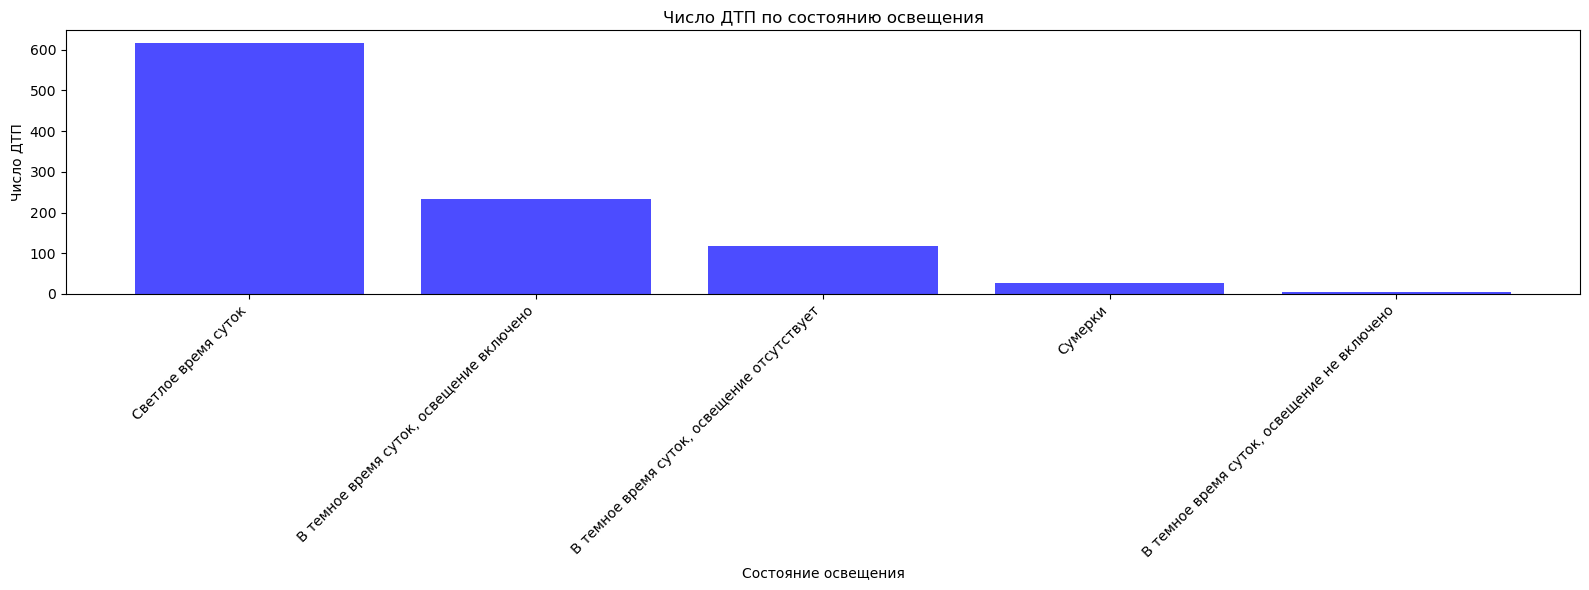

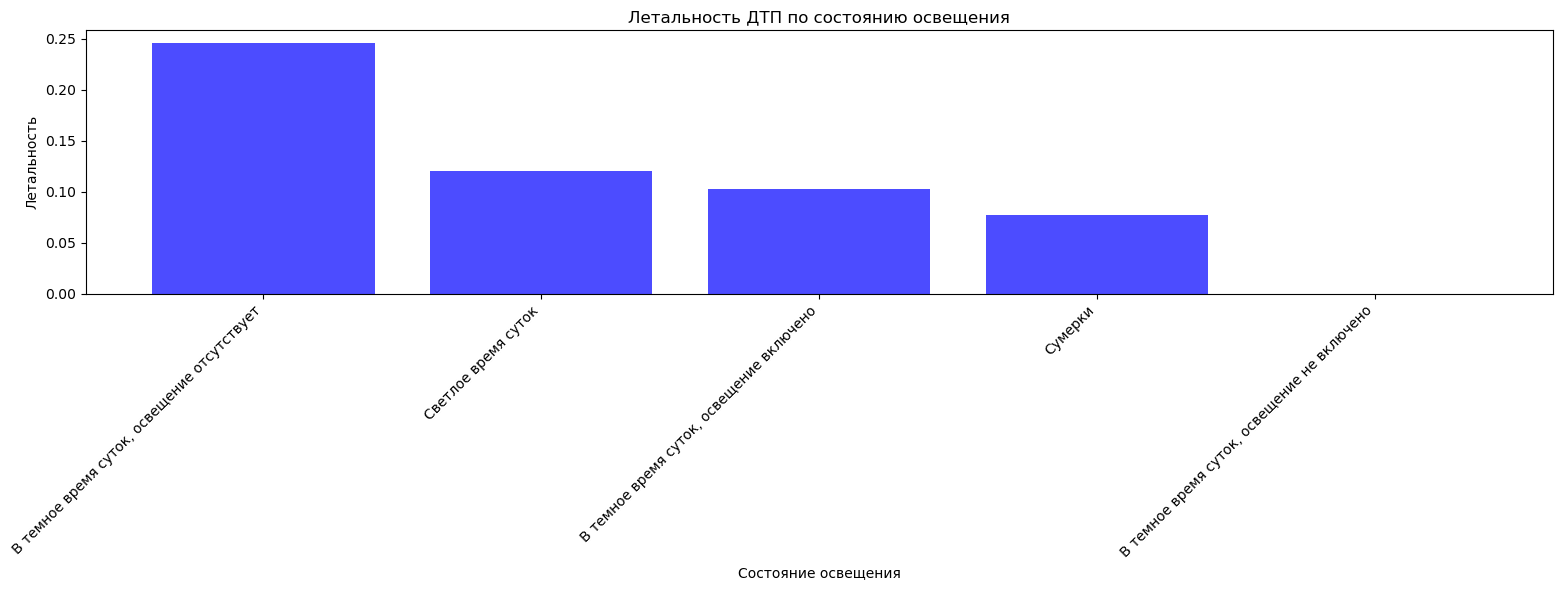

In [29]:
from utils import aggregate_metrics, compute_rate, plot_bar_chart

# Агрегация: число ДТП и число погибших по состоянию освещения
light_stats = aggregate_metrics(
    df        = accidents,
    group_col = 'light',
    metrics   = {
        'accident_count': ('id',         'size'),
        'death_count':    ('dead_count', 'sum')
    }
)

# Расчёт fatality_rate = погибших на 1 ДТП
light_stats = compute_rate(
    df          = light_stats,
    numerator   = 'death_count',
    denominator = 'accident_count',
    new_col     = 'fatality_rate',
    multiplier  = 1
)

# Гистограмма числа ДТП, отсортированная по убыванию
light_by_count = light_stats.sort_values('accident_count', ascending=False)
plot_bar_chart(
    df      = light_by_count,
    x       = 'light',
    y       = 'accident_count',
    title   = 'Число ДТП по состоянию освещения',
    xlabel  = 'Состояние освещения',
    ylabel  = 'Число ДТП'
)

# Гистограмма fatality_rate, отсортированная по убыванию
light_by_fatality = light_stats.sort_values('fatality_rate', ascending=False)
plot_bar_chart(
    df      = light_by_fatality,
    x       = 'light',
    y       = 'fatality_rate',
    title   = 'Летальность ДТП по состоянию освещения',
    xlabel  = 'Состояние освещения',
    ylabel  = 'Летальность'
)

##### Выводы

- **По числу ДТП** (самые частые условия освещения):
  1. **Светлое время суток** – 617 аварий  
  2. **В темное время суток, освещение включено** – 234 аварии  
  3. **В темное время суток, освещение отсутствует** – 118 аварий  
  4. **Сумерки** – 26 аварий  
  5. **В темное время суток, освещение не включено** – 5 аварий  

- **По летальности ДТП** (погибших на 1 ДТП):
  1. **В темное время суток, освещение отсутствует** – ≈0.25 погибших  
  2. **Светлое время суток** – ≈0.12  
  3. **В темное время суток, освещение включено** – ≈0.10  
  4. **Сумерки** – ≈0.08  
  5. **В темное время суток, освещение не включено** – 0.00
> Данные выборочные, объём по некоторым категориям мал, поэтому результаты носят иллюстративный характер и требуют проверки на полном наборе ДТП.

## ДТП и летальность по погодным условиям

В этом блоке мы:
- Группируем данные по погодным условиям (`weather`) и считаем:
  - `accident_count` – число ДТП;
  - `death_count` – число погибших.
- Вычисляем `fatality_rate` = погибших на 1 ДТП.
- Строим гистограммы в порядке убывания:
  1. Количество ДТП;
  2. Летальность.

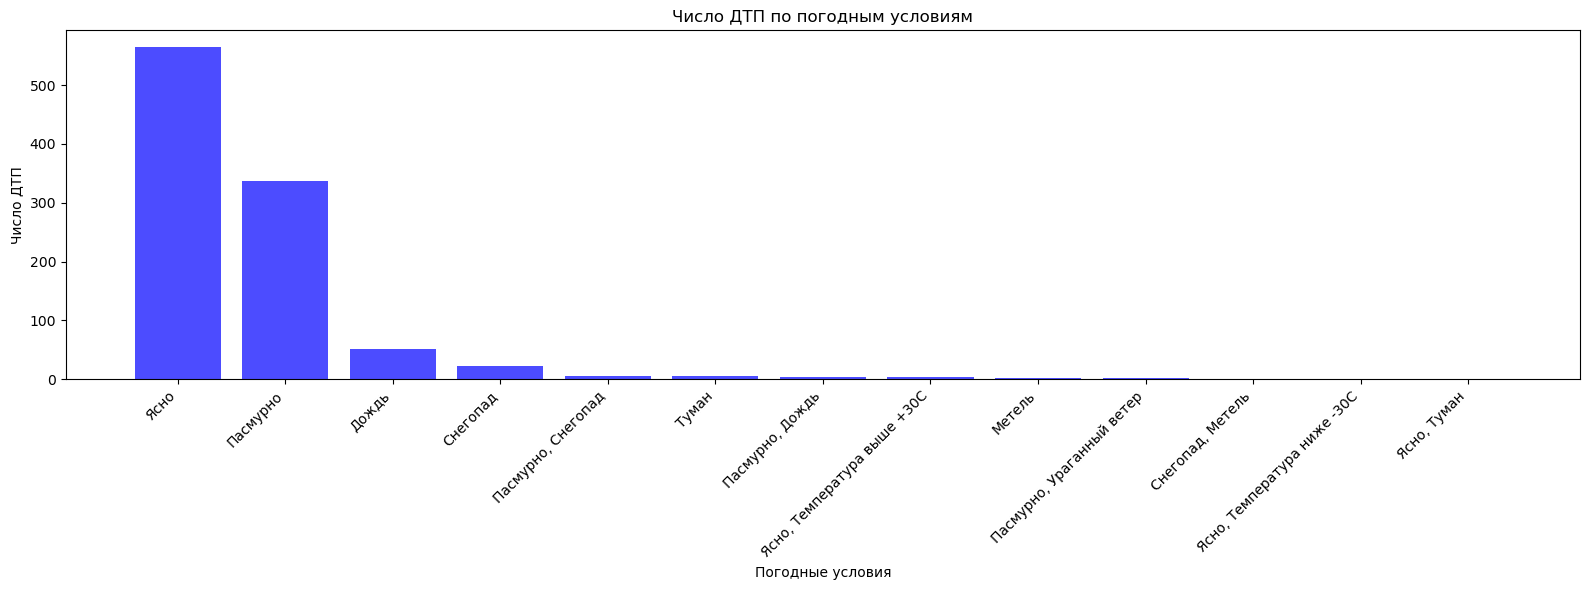

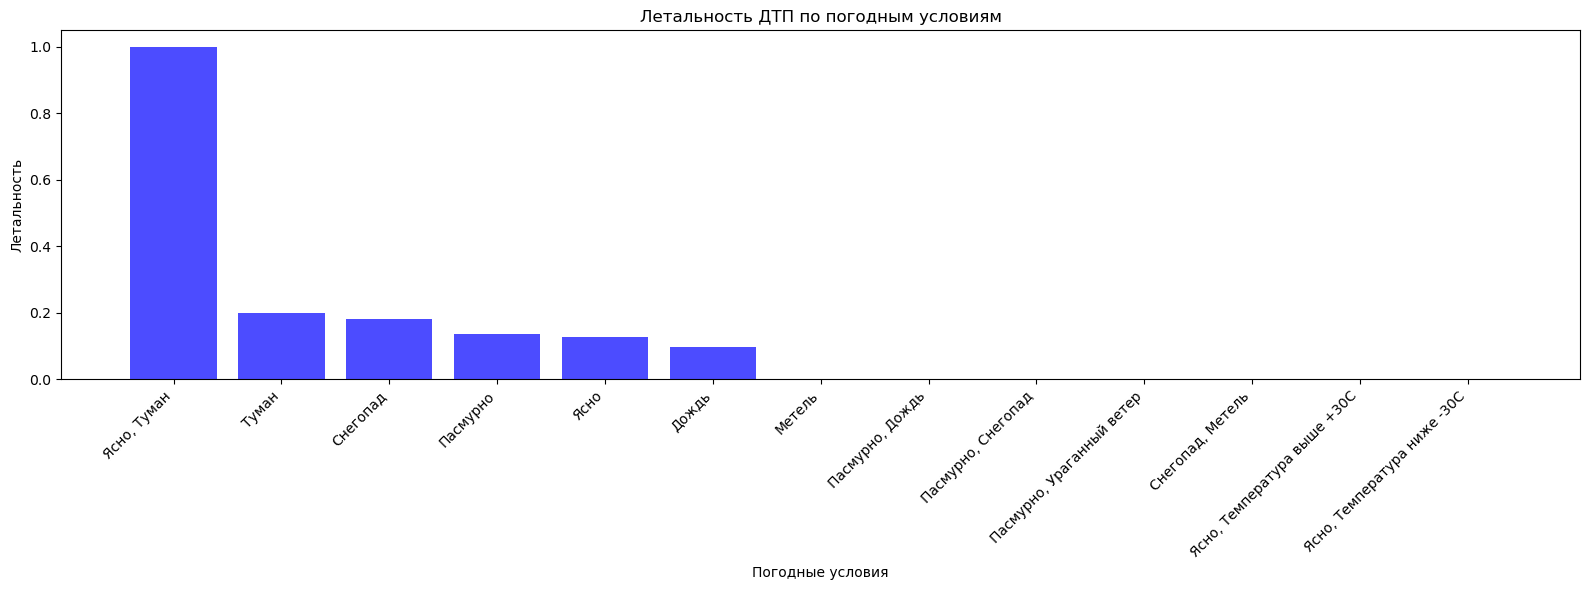

In [32]:
from utils import aggregate_metrics, compute_rate, plot_bar_chart

weather_stats = aggregate_metrics(
    df        = accidents,
    group_col = 'weather',
    metrics   = {
        'accident_count': ('id',         'size'),
        'death_count':    ('dead_count', 'sum')
    }
)

weather_stats = compute_rate(
    df          = weather_stats,
    numerator   = 'death_count',
    denominator = 'accident_count',
    new_col     = 'fatality_rate',
    multiplier  = 1
)

sorted_by_count = weather_stats.sort_values('accident_count', ascending=False)
plot_bar_chart(
    df     = sorted_by_count,
    x      = 'weather',
    y      = 'accident_count',
    title  = 'Число ДТП по погодным условиям',
    xlabel = 'Погодные условия',
    ylabel = 'Число ДТП'
)

sorted_by_fatality = weather_stats.sort_values('fatality_rate', ascending=False)
plot_bar_chart(
    df     = sorted_by_fatality,
    x      = 'weather',
    y      = 'fatality_rate',
    title  = 'Летальность ДТП по погодным условиям',
    xlabel = 'Погодные условия',
    ylabel = 'Летальность'
)

## Выводы

- Наибольшее число ДТП зарегистрировано при **ясной** погоде (≈570 аварий), что во многом связано с высокой интенсивностью дорожного движения в благоприятных условиях.  
- **Пасмурная** погода находится на втором месте (≈340 ДТП), тогда как при **дожде** (≈50 ДТП) и **снегопаде** (≈20 ДТП) аварий заметно меньше, несмотря на ухудшение сцепления.  
- Показатель **летальности** максимален при сочетании условий **«ясно + туман»** (≈1 погибший на ДТП) и в чистом **тумане** (≈0,20), что указывает на наибольшую смертельную опасность при ограниченной видимости.  
- Повышенная летальность также наблюдается при **снегопаде** (≈0,18) и **дожде** (≈0,10) — эти условия требуют особого внимания служб дорожной безопасности.  
- **Важно:** выборочные данные и малое число ДТП в некоторых категориях снижают статистическую надёжность; для окончательных выводов следует проверить полный набор данных.

## Распределение числа участников ДТП (до 10 участников)

В этом блоке мы:
- Строим распределение ДТП по количеству участников (от 1 до 10 человек).
- Строим гистограмму для числа участников

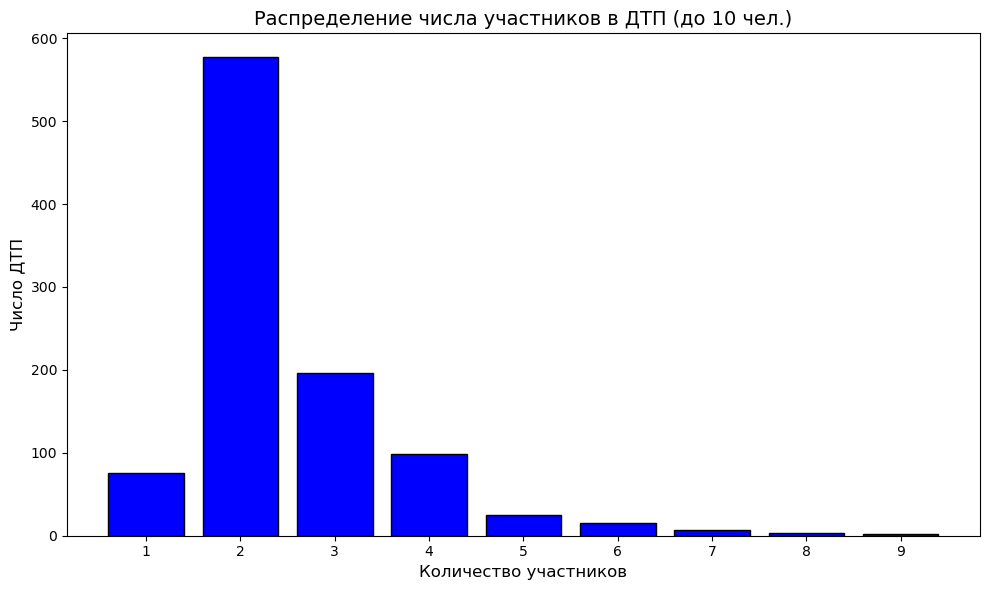

In [35]:
from utils import aggregate_metrics, plot_bar_chart

# Группируем по числу участников и считаем число ДТП
participants_stats = aggregate_metrics(
    df        = accidents,
    group_col = 'participants_count',
    metrics   = {'accident_count': ('id', 'size')}
)

# Фильтруем до 10 участников и сортируем по возрастанию числа участников
participants_stats = (
    participants_stats
    .loc[participants_stats['participants_count'] < 11]
    .sort_values('participants_count')
    .reset_index(drop=True)
)

# Рисуем столбчатую диаграмму
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    participants_stats['participants_count'],
    participants_stats['accident_count'],
    color='blue',
    edgecolor='black'
)

# Остальная настройка
ax.set_xlabel('Количество участников', fontsize=12)
ax.set_ylabel('Число ДТП', fontsize=12)
ax.set_title('Распределение числа участников в ДТП (до 10 чел.)', fontsize=14)
ax.set_xticks(participants_stats['participants_count'])
ax.grid(False)
plt.tight_layout()
plt.show()

## Выводы

- Бóльшая часть ДТП (≈58 %) приходится на аварии с **двумя участниками** (577 случаев), что соответствует типичным столкновениям двух ТС или «водитель—пешеход».  
- На **трёх участников** приходится около 20 % всех ДТП (196 случаев), а на **четвёрку** — почти 10 % (98 случаев).  
- **Одиночные** ДТП (76 случаев, ≈7,6 %) в большинстве представляют опрокидывания или наезды без вовлечения других участников.  
- Многопользовательские аварии с **5 и более участниками** встречаются крайне редко (в сумме <3 % выборки).  
- Данные выборочны, и `participants_count` может не учитывать всех пассажиров, поэтому для надёжных выводов стоит проверить логику подсчёта участников в полном наборе.

## Распределение числа погибших в ДТП

В этом блоке мы:
- Считаем, сколько ДТП было с разным числом погибших.
- Строим гистограмму.

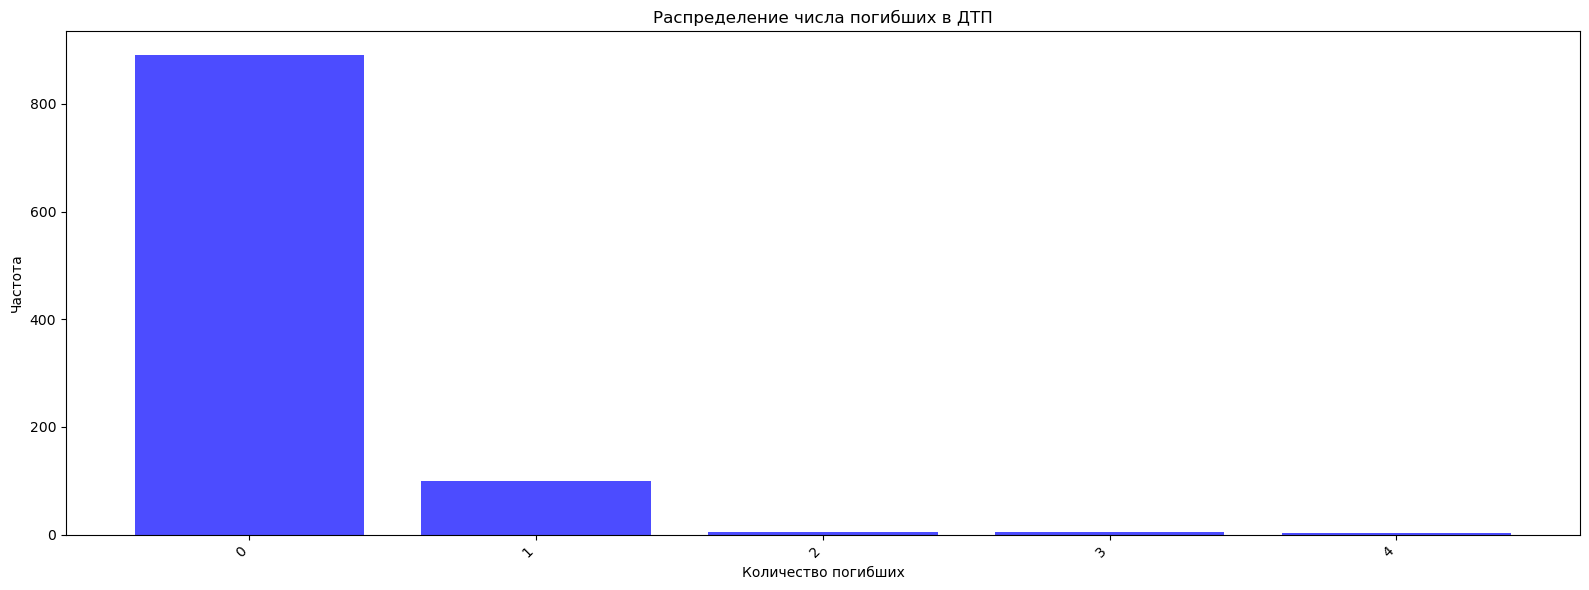

In [38]:
from utils import aggregate_metrics, plot_bar_chart

# Собираем распределение по числу погибших
death_stats = aggregate_metrics(
    df        = accidents,
    group_col = 'dead_count',
    metrics   = {'frequency': ('dead_count', 'size')}
).sort_values('dead_count').reset_index(drop=True)

# Строим гистограмму
plot_bar_chart(
    df      = death_stats,
    x       = 'dead_count',
    y       = 'frequency',
    title   = 'Распределение числа погибших в ДТП',
    xlabel  = 'Количество погибших',
    ylabel  = 'Частота'
)

## Выводы

- Большинство ДТП заканчиваются **без погибших** (значение 0), что хорошо отражает долю нефатальных происшествий.  
- ДТП с **одним погибшим** встречаются значительно реже, но составляют заметную часть от общего объёма фатальных аварий.  
- С увеличением числа погибших выше 1 частота аварий быстро падает — случаи с 2 и более смертельными исходами редки.  
- Данные выборочны, реальная доля фатальных ДТП в полной базе может отличаться.

In [40]:
## Распределение числа пострадавших в ДТП

В этом блоке мы:
- Считаем, сколько ДТП было с разным числом ранненых.
- Строим гистограмму для числа раненных.

SyntaxError: invalid syntax (855086184.py, line 3)

In [ ]:
from utils import aggregate_metrics, plot_bar_chart

# Собираем распределение по числу раненых
injured_stats = aggregate_metrics(
    df        = accidents,
    group_col = 'injured_count',
    metrics   = {'frequency': ('injured_count', 'size')}
).sort_values('injured_count').reset_index(drop=True)

# Строим гистограмму
plot_bar_chart(
    df      = injured_stats,
    x       = 'injured_count',
    y       = 'frequency',
    title   = 'Распределение числа пострадавших в ДТП',
    xlabel  = 'Количество раненых',
    ylabel  = 'Частота'
)

## Выводы

- Бóльшая часть ДТП (≈75 % случаев) приходится на аварии с **одним раненым**, что указывает на преобладание ситуаций «водитель + один пассажир» или «водитель + один пешеход».  
- ДТП без пострадавших (≈7 % случаев) и с двумя раненными (≈12 %) встречаются реже, но всё же составляют значимую часть выборки.  
- С числом пострадавших более трёх аварии становятся очень редкими (≤3 %), а ДТП с четырьмя и более раненными практически не влияют на общую картину.  
- Эти данные вновь подчеркивают, что большинство аварий затрагивает небольшое число участников, однако метод учёта травм может быть неполным и требует верификации на полном массиве данных.

## Аварии с нарушениями

В этом блоке мы:
- Объединяем данные участников и аварий;
- Определяем общее число уникальных ДТП;
- Считаем долю аварий с любыми нарушениями, с нарушениями со стороны водителя и со стороны пешехода;
- Выводим результаты в процентах.

In [ ]:
# Объединение таблиц участников и аварий
merged_data = participants.merge(
    accidents.rename(columns={'id': 'accident_id'}),
    on='accident_id',
    how='inner'
)

# Общее число уникальных ДТП
total_accidents = merged_data['accident_id'].nunique()

# % ДТП с любыми нарушениями
accidents_with_violation = merged_data[merged_data['violations'].notna()]['accident_id'].nunique()
percent_with_violation = accidents_with_violation / total_accidents * 100

# % ДТП с нарушениями со стороны водителя
driver_violations = merged_data[
    (merged_data['violations'].notna()) &
    (merged_data['role'] == 'Водитель')
]['accident_id'].nunique()
percent_driver_violation = driver_violations / total_accidents * 100

# % ДТП с нарушениями со стороны пешехода
pedestrian_violations = merged_data[
    (merged_data['violations'].notna()) &
    (merged_data['role'] == 'Пешеход')
]['accident_id'].nunique()
percent_pedestrian_violation = pedestrian_violations / total_accidents * 100

# Выводим результаты
print(f"Процент ДТП с нарушениями: {percent_with_violation:.1f}%")
print(f"Процент ДТП с нарушениями со стороны водителя: {percent_driver_violation:.1f}%")
print(f"Процент ДТП с нарушениями со стороны пешехода: {percent_pedestrian_violation:.1f}%")

## Выводы

- Практически все аварии в выборке связаны с теми или иными нарушениями правил дорожного движения.  
- Значительная часть ДТП обусловлена нарушениями, допущенными водителями.  
- Нарушения со стороны пешеходов встречаются значительно реже и затрагивают лишь небольшую долю аварий.

> Данные выборочные и требуют проверки на полном наборе для надёжных оценок.

## Анализ ДТП по полу участников и водителей

В этом разделе мы исследуем, как пол участников влияет на статистику аварий и летальность:
- Сначала сравниваем мужчин и женщин среди **всех** участников ДТП: сколько аварий приходится на каждый пол и какова доля погибших на 100 ДТП.
- Затем повторяем те же расчёты только для **водителей**, поскольку они в большей степени контролируют ситуацию на дороге.

In [ ]:
from utils import aggregate_metrics, compute_rate
from IPython.display import display, Markdown

# Объединяем участников и данные ДТП
merged_data = participants.merge(
    accidents.rename(columns={'id': 'accident_id'}),
    on='accident_id',
    how='inner'
)

# Анализ по полу всех участников
gender_stats = aggregate_metrics(
    df        = merged_data,
    group_col = 'gender',
    metrics   = {
        'accident_count': ('accident_id', 'nunique'),
        'death_count':    ('dead_count',   'sum')
    }
)
gender_stats = compute_rate(
    df          = gender_stats,
    numerator   = 'death_count',
    denominator = 'accident_count',
    new_col     = 'fatality_rate',
    multiplier  = 100
).round({'fatality_rate': 1})

# Анализ по полу только водителей
driver_stats = aggregate_metrics(
    df        = merged_data.query("role == 'Водитель'"),
    group_col = 'gender',
    metrics   = {
        'accident_count': ('accident_id', 'nunique'),
        'death_count':    ('dead_count',   'sum')
    }
)
driver_stats = compute_rate(
    df          = driver_stats,
    numerator   = 'death_count',
    denominator = 'accident_count',
    new_col     = 'fatality_rate',
    multiplier  = 100
).round({'fatality_rate': 1})

# Заголовки и вывод таблиц
display(Markdown("### Статистика по полу всех участников"))
display(gender_stats)

display(Markdown("### Статистика по полу только водителей"))
display(driver_stats)

## Выводы

- **Все участники**:
  - Женщины: 529 ДТП, 107 погибших (летальность 20.2%);
  - Мужчины: 951 ДТП, 278 погибших (летальность 29.2%).
  Мужчины участвуют в авариях чаще и такие аварии имеют более высокий процент погибших.

- **Только водители**:
  - Женщины: 198 ДТП, 17 погибших (летальность 8.6%);
  - Мужчины: 891 ДТП, 189 погибших (летальность 21.2%).
  При учете только водителей аварии с водителями-мужчинами также более смертоносны, чем с водителями женщинами, и эта разница выше, чем для всех участников.
  
> Данные выборочные и требуют проверки на полном наборе для надёжных выводов.  

## Аварии по роли участника

В этом блоке мы:
- Группируем все ДТП по роли (`role`) участника (водитель, пешеход и т. д.);
- Считаем число уникальных аварий (`accident_count`) и общее число погибших (`death_count`);
- Вычисляем `fatality_rate` = погибших на 100 ДТП;
- Сортируем роли по убыванию числа погибших для наглядности.

In [ ]:
from utils import aggregate_metrics, compute_rate
from IPython.display import display, Markdown

# Анализ аварий по роли участника
role_stats = aggregate_metrics(
    df        = merged_data,
    group_col = 'role',
    metrics   = {
        'accident_count': ('accident_id', 'nunique'),
        'death_count':    ('dead_count',   'sum')
    }
)

role_stats = compute_rate(
    df          = role_stats,
    numerator   = 'death_count',
    denominator = 'accident_count',
    new_col     = 'fatality_rate',
    multiplier  = 100
).round({'fatality_rate': 1})

# Сортируем по убыванию числа погибших
role_stats = role_stats.sort_values('death_count', ascending=False).reset_index(drop=True)

display(Markdown("### Аварии по роли участников"))
display(role_stats)

## Выводы

- **Водители** участвуют в подавляющем большинстве аварий (991 ДТП) и обеспечивают значительное число погибших, однако летальность аварий с их участием составляет около 22 %.  
- **Пассажиры** значительно реже (367 ДТП), но имеют самую высокую летальность — 38 %, что говорит о повышенной смертельной опасности при пассажирских авариях.  
- **Пешеходы** участвуют в 318 ДТП с летальностью ≈ 11 %, а **велосипедисты** в 31 ДТП с летальностью ≈ 13 %. Оба эти показателя ниже, чем у пассажиров и водителей.  
- Специфическая категория «пешеход перед ДТП находившийся в (на) ТС» (7 ДТП, 2 погибших) демонстрирует летальность ≈ 29 %, но малое число случаев снижает надёжность вывода.  
- Итоги подчёркивают необходимость фокусных мер безопасности для пассажиров (особенно при фронтальных столкновениях) и повышения защиты уязвимых участников (пешеходов и велосипедистов).  
- **Внимание:** данные выборочны и требуют проверки на полном массиве ДТП для подтверждения тенденций.  

## ДТП по виду транспортного средства

Здесь мы объединяем данные о ДТП и информацию о задействованных транспортных средствах, определяем топ-10 типов ТС по числу аварий и строим соответствующую диаграмму.

In [ ]:
from utils import aggregate_metrics, plot_bar_chart
from IPython.display import display, Markdown

# объединяем аварии и данные по ТС
merged = accidents.merge(
    vehicles.rename(columns={'category': 'vehicle_type'}),
    left_on='id',
    right_on='accident_id',
    how='left'
)

# агрегируем число уникальных ДТП по типу ТС
vehicle_stats = aggregate_metrics(
    df        = merged,
    group_col = 'vehicle_type',
    metrics   = {'accident_count': ('accident_id', 'nunique')}
)

# берём топ-10 видов ТС
top_vehicles = vehicle_stats.nlargest(10, 'accident_count').reset_index(drop=True)

display(Markdown("### Топ-10 видов ТС по числу ДТП"))
display(top_vehicles)

# строим диаграмму
plot_bar_chart(
    df     = top_vehicles,
    x      = 'vehicle_type',
    y      = 'accident_count',
    title  = 'Топ-10 видов транспортных средств по числу ДТП',
    xlabel = 'Тип транспортного средства',
    ylabel = 'Число ДТП'
)

## Выводы

- Абсолютными лидерами по участию в ДТП являются легковые автомобили B-класса, за ними следуют компактные C-класс и автомобили среднего D-класса.  
- В топ-5 также входят прочие легковые модели (A-класс и прочие), хотя их доля в авариях заметно меньше, чем у трёх основных классов.  
- Мотоциклы и сельскохозяйственная техника (тракторы) демонстрируют умеренный уровень аварийности, уступая массовым легковым транспортным средствам.  
- Грузовые фургоны и внедорожники (SUV) занимают среднюю позицию по числу ДТП, отражая свою относительную распространённость на дорогах.  
- Велосипеды и другие маломощные ТС участвуют в авариях реже всего и вносят минимальный вклад в общую статистику.  
> Поскольку выборка ограничена, эти наблюдения стоит подтвердить на полных данных.  

## Летальность ДТП в зависимости от возраста транспортного средства

В этом блоке мы:
- Вычисляем возраст ТС как разницу между годом аварии и годом выпуска.
- Группируем по возрасту и считаем число ДТП и число погибших.
- Рассчитываем `fatality_rate` — погибших на 100 ДТП.
- Строим точечный график зависимости летальности от возраста ТС, ограничивая возраст 50 годами.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Добавляем возраст ТС
merged['car_age'] = merged['year'] - merged['manufacture_year']

# Группируем по возрасту ТС
age_stats = (
    merged
    .groupby('car_age')
    .agg(
        accident_count=('accident_id', 'nunique'),
        dead_count    =('dead_count',    'sum')
    )
    .reset_index()
)

# Рассчитываем fatality_rate = погибших на 100 ДТП
age_stats['fatality_rate'] = (age_stats['dead_count'] / age_stats['accident_count']) * 100

# Фильтрация по возрасту до 50 лет
age_stats = age_stats[age_stats['car_age'] < 50]

# Линейный график с маркерами
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    age_stats['car_age'],
    age_stats['fatality_rate'],
    marker='o',
    linestyle='-',
    linewidth=2,
    markersize=6
)
ax.set_title('Летальность ДТП в зависимости от возраста ТС', fontsize=14)
ax.set_xlabel('Возраст ТС (лет)', fontsize=12)
ax.set_ylabel('Летальность (погибших на 100 ДТП)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()